Train and compare GP regression models using each encoding for each task. 

In [1]:
import os
import pickle
import itertools

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import metrics
import seaborn as sns
import pandas as pd
from sklearn import model_selection

import gpm
import gpk
import stringkernel

%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

plt.rcParams.update({'axes.grid': False})


assert np.__version__ == '1.13.1'
assert pd.__version__ == '0.20.3'

In [2]:
def select_X_and_Y(df, all_X, y_column):
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped][y_column]
    Ys.index = df[not_dropped]['name']
    Xs = all_X.loc[Ys.index]
    return Xs, Ys

def score(Y, pred_Y, pred_var):
    r1 = stats.rankdata(Y)
    r2 = stats.rankdata(pred_Y)
    scores = {}
    scores['kendalltau'] = stats.kendalltau(r1, r2).correlation
    scores['R2'] = metrics.r2_score(Y, pred_Y)
    scores['mae'] = metrics.mean_absolute_error(Y, pred_Y)
    scores['SE'] = metrics.mean_squared_error(Y, pred_Y)
    scores['R'] = np.corrcoef(Y, pred_Y)[0, 1]
    log_ps = -0.5 * np.log(pred_var) - (pred_Y - Y)**2 / 2 / pred_var
    log_ps -= 0.5 * np.log(2 * np.pi)
    scores['log_loss'] = -np.sum(log_ps)
    return scores

def evaluate(df_train, df_test, X, task, X_name, guesses=None, kernel='matern'):
    X_train, y_train = select_X_and_Y(df_train, X, task)
    X_test, y_test = select_X_and_Y(df_test, X, task)
    n_train, d = X_train.shape
    n_test, d = X_test.shape
    if kernel == 'matern':
        k = gpk.MaternKernel('5/2')
    if kernel == 'cubic':
        k = gpk.PolynomialKernel(3)
    clf = gpm.GPRegressor(k, guesses=guesses)
    clf.fit(X_train, y_train)
    print(X_name)
    print(clf.hypers)
    mu, var = clf.predict(X_test)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = task
    met1['X'] = X_name
    met1['d'] = d
    met1['n_train'] = n_train
    met1['n_test'] = n_test
    met1['kernel'] = kernel
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

def evaluate_mismatch(df, df_train, df_test, y_col, k, m, guesses=None):
    A = sorted(set(itertools.chain.from_iterable(df['sequence'].values)))
    ke = stringkernel.MismatchKernel(k, A, m)
    X = df[['sequence']]
    X.index = df['name']
    X_train, y_train = select_X_and_Y(df_train, X, y_col)
    X_test, y_test = select_X_and_Y(df_test, X, y_col)
    clf = gpm.GPRegressor(ke, guesses=guesses)
    clf.fit(X_train['sequence'].values, y_train)
    print(k, m)
    print(clf.hypers)
    mu, var = clf.predict(X_test['sequence'].values)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = y_col
    met1['X'] = ''
    met1['n_train'] = len(y_train)
    met1['n_test'] = len(y_test)
    met1['kernel'] = 'mismatch_' + str(k) + '_' + str(m)
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

def plot_results(ax, y_test, mu, title):
    _ = ax.plot(y_test, mu, 'o', alpha=0.8, ms=10)
    _ = ax.set_title(title)
    _ = ax.text(0.05, 0.9, 
                r'$\tau$ = %0.2f, MAE = %0.2f' %(evals.loc[0, 'kendalltau'], evals.loc[0, 'mae']), 
                transform=ax.transAxes, fontsize=15)

In [3]:
with open('../inputs/X_aaindex_64_cosine.pkl', 'rb') as f:
    X_aa = pickle.load(f)

In [4]:
res = pd.DataFrame(index=[], columns=['task', 'X', 'd', 'n_train', 'n_test', 
                                      'kernel', 'R', 'R2', 'SE', 'kendalltau', 'log_loss'])

### Localization

/Users/kevinyang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kevinyang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


seq_struc
[  0.13462925  19.65223413]
CPU times: user 55.1 s, sys: 3.1 s, total: 58.2 s
Wall time: 58 s
seq
[ 0.22018101  7.85940934]
CPU times: user 1.09 s, sys: 68.5 ms, total: 1.16 s
Wall time: 748 ms
aaindex
[  2.48511772e-01   9.76236390e+02]
profet
[  0.79463775  99.99989796]
CPU times: user 472 ms, sys: 38.4 ms, total: 510 ms
Wall time: 232 ms
5 1
[ 0.69845913  0.9032765 ]
X_scrambled_3_5
[ 0.25197468  0.43406704]
CPU times: user 1.43 s, sys: 66.4 ms, total: 1.5 s
Wall time: 431 ms


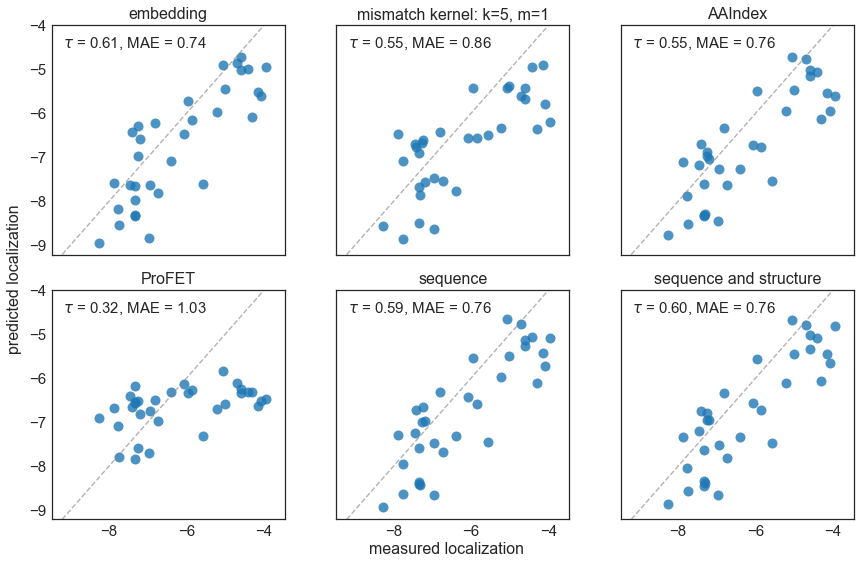

In [5]:
y_col = 'log_GFP'
dataset = '../inputs/localization.txt'
embedding_dirs = '../outputs/localization_embeddings/'
emb = 'X_scrambled_3_5.pkl'
fig, axs = plt.subplots(2, 3, figsize=(12, 7.5))
fig.tight_layout()

df = pd.read_csv(dataset)
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]

df_test['is_train'] = [False for _ in range(len(df_test))]
df_train['is_train'] = [True for _ in range(len(df_train))]


# Sequence and structure
with open('../inputs/localization_seq_struct.pkl', 'rb') as f:
    X_all, _ = pickle.load(f)
%time evals, mu = evaluate(df_train, df_test, X_all, y_col, 'seq_struc')
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 2], y_test, mu, 'sequence and structure')

# Sequence
with open('../inputs/localization_seq.pkl', 'rb') as f:
    X_seq, _ = pickle.load(f)
%time evals, mu = evaluate(df_train, df_test, X_seq, y_col, 'seq')
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 1], y_test, mu, 'sequence')


# AAIndex
evals, mu = evaluate(df_train, df_test, X_aa['log_GFP_True'], y_col, 'aaindex', guesses=(10, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 2], y_test, mu, 'AAIndex')


# ProFET
X_p = pd.read_csv('../inputs/localization_profet.tsv', delimiter='\t')
X_p.index = X_p['name']
del X_p['name']
%time evals, mu = evaluate(df_train, df_test, X_p, y_col, 'profet', guesses=(0.1, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 0], y_test, mu, 'ProFET')

# Mismatch Kernel
evals, mu = evaluate_mismatch(df, df_train, df_test, y_col, 5, 1)
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 1], y_test, mu, 'mismatch kernel: k=5, m=1')


# Embedding
with open(embedding_dirs + emb, 'rb')  as f:
    X, _ = pickle.load(f)
%time evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(0.1, 10))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 0], y_test, mu, 'embedding')

for i in range(2):
    for j in range(3):
        y0 = -9.2
        y1 = -4
        axs[i, j].set_ylim([y0, y1])
        x0, x1 = axs[i, j].get_xlim()
        _ = axs[i, j].plot([y0, x1], [y0, x1], '--', color='grey', alpha=0.6)
        if i != 1:
            axs[i, j].get_xaxis().set_visible(False)
        if j != 0:
            axs[i, j].get_yaxis().set_visible(False)
_ = fig.text(0.5, 0.0, 'measured localization', ha='center', va='center', fontsize=16)
_ = fig.text(0.0, 0.5, 'predicted localization', ha='center', va='center', rotation=90, fontsize=16)

In [6]:
res[res['task'] == 'log_GFP']

,R,R2,SE,X,d,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,0.846901,0.538234,0.797441,seq_struc,600747,0.598485,matern,43.158872,0.762604,33,215,log_GFP
1,0.841457,0.537148,0.799316,seq,7161,0.587121,matern,43.682072,0.758927,33,215,log_GFP
2,0.823871,0.513119,0.840812,aaindex,21824,0.549242,matern,44.330349,0.760915,33,215,log_GFP
3,0.461800,0.085362,1.579522,profet,1173,0.321970,matern,54.851747,1.026543,33,215,log_GFP
4,0.758437,0.434493,0.976596,,NaN,0.549242,mismatch_5_1,47.431743,0.855876,33,215,log_GFP
5,0.834091,0.540873,0.792884,X_scrambled_3_5,64,0.606061,matern,43.483401,0.735613,33,215,log_GFP


seq
[  1.00000000e-05   2.58294760e+00]
CPU times: user 107 ms, sys: 3.49 ms, total: 111 ms
Wall time: 99.9 ms
aaindex
[  1.33241200e-01   2.36857946e+02]
CPU times: user 12.7 ms, sys: 956 µs, total: 13.6 ms
Wall time: 3.93 ms
profet
[  0.27231752  18.7180501 ]
CPU times: user 178 ms, sys: 16.7 ms, total: 195 ms
Wall time: 83.9 ms
5 1
[  0.05178362  14.55707575]
X_uniform_4_1
[  1.00000000e-05   2.61140444e-01]
CPU times: user 192 ms, sys: 16 ms, total: 208 ms
Wall time: 62.8 ms


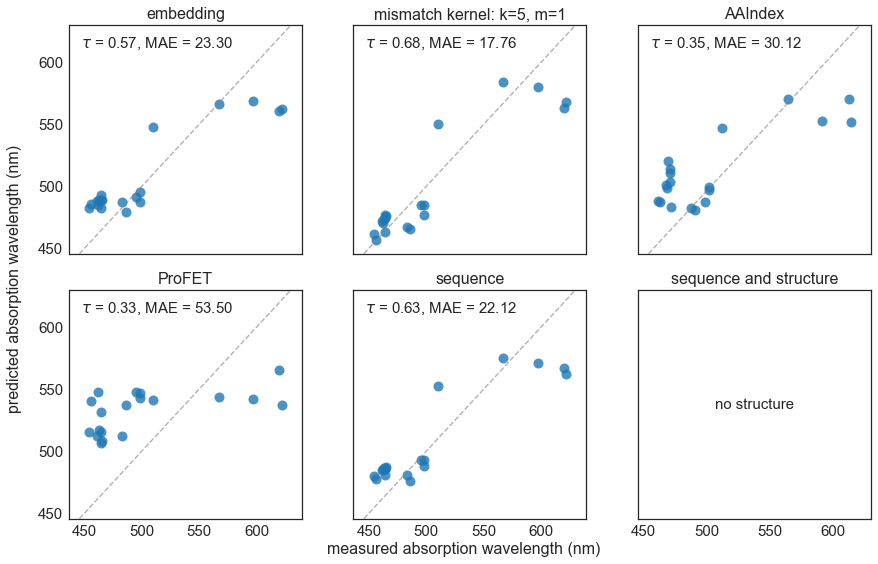

In [7]:
y_col = 'peak'
dataset = '../inputs/absorption.txt'
e_dir = '../outputs/absorption_embeddings/'
emb = 'X_uniform_4_1.pkl'
df = pd.read_csv(dataset)
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]
fig, axs = plt.subplots(2, 3, figsize=(12, 7.5))
fig.tight_layout()


# Sequence
with open('../inputs/absorption_seq.pkl', 'rb') as f:
    X, _ = pickle.load(f)
%time evals, mu = evaluate(df_train, df_test, X, y_col, 'seq')
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 1], y_test, mu, 'sequence')


# AAIndex
evals, mu = evaluate(df_train, df_test, X_aa['peak_True'], y_col, 'aaindex', guesses=(10, 100))
%time res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 2], y_test, mu, 'AAIndex')

# ProFET
X_p = pd.read_csv('../inputs/absorption_profet.tsv', delimiter='\t')
X_p.index = X_p['name']
del X_p['name']
%time evals, mu = evaluate(df_train, df_test, X_p, y_col, 'profet', guesses=(10, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 0], y_test, mu, 'ProFET')


# # Mismatch
evals, mu = evaluate_mismatch(df, df_train, df_test, y_col, 5, 1)
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 1], y_test, mu, 'mismatch kernel: k=5, m=1')


# Embedding
with open(e_dir + emb, 'rb')  as f:
    X, _ = pickle.load(f)
%time evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(10, 10))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 0], y_test, mu, 'embedding')

_ = axs[1, 2].set_title('sequence and structure')
_ = axs[1, 2].text(0.5, 0.5, 'no structure', ha='center', va='center', 
              transform=axs[1, 2].transAxes, fontsize=15)
for i in range(2):
    for j in range(3):
        y0 = 445
        y1 = 630
        axs[i, j].set_ylim([y0, y1])
        if i == 1 and j == 2:
            axs[i, j].set_xlim([x0, x1])
        else:
            x0, x1 = axs[i, j].get_xlim()
            _ = axs[i, j].plot([x0, x1], [x0, x1], '--', color='grey', alpha=0.6)
        if i != 1:
            axs[i, j].get_xaxis().set_visible(False)
        if j != 0:
            axs[i, j].get_yaxis().set_visible(False)
_ = fig.text(0.5, 0.0, 'measured absorption wavelength (nm)', ha='center', va='center', fontsize=16)
_ = fig.text(-0.02, 0.5, 'predicted absorption wavelength (nm)', ha='center', va='center', rotation=90, fontsize=16)

In [8]:
res[res['task'] == 'peak']

,R,R2,SE,X,d,kendalltau,kernel,log_loss,mae,n_test,n_train,task
6,0.912422,0.761582,718.450266,seq,6258,0.629105,matern,111.028433,22.119197,19,62,peak
7,0.821902,0.552678,1347.963226,aaindex,19072,0.349137,matern,116.404173,30.120252,19,62,peak
8,0.588761,-0.047222,3155.707070,profet,1174,0.325467,matern,174.711080,53.496485,19,62,peak
9,0.914262,0.816947,551.612437,,NaN,0.680521,mismatch_5_1,103.918555,17.760964,19,62,peak
10,0.917127,0.730495,812.127468,X_uniform_4_1,64,0.574005,matern,109.240287,23.301412,19,62,peak


seq_struc
[  0.0439616   41.70153085]
seq
[  0.04471689  14.36159256]
aaindex
[  5.00189770e-02   1.72665172e+03]
profet
[  0.27252491  49.11521774]
5 1
[ 0.17295582  1.96016369]
X_original_4_5
[ 0.04115126  0.73060142]


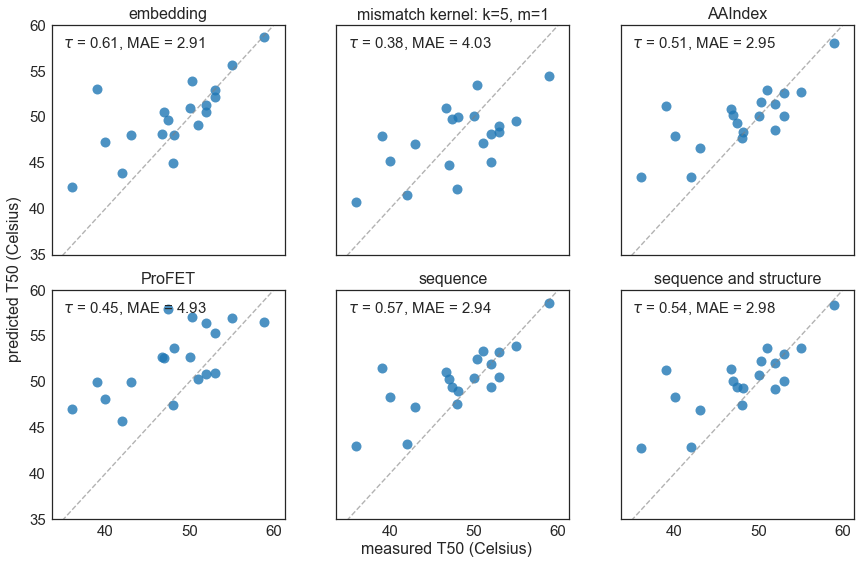

In [9]:
y_col = 'T50'
dataset = '../inputs/T50.txt'
e_dir = '../outputs/T50_embeddings/'
emb = 'X_original_4_5.pkl'
df = pd.read_csv(dataset)
df_train = df[df.is_train]
df_test = df[~df.is_train]

y_test = df_test.dropna(subset=[y_col])[y_col]
fig, axs = plt.subplots(2, 3, figsize=(12, 7.5))
fig.tight_layout()

# Sequence and structure
with open('../inputs/T50_seq_struct.pkl', 'rb') as f:
    X, _ = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, 'seq_struc', guesses=(1, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 2], y_test, mu, 'sequence and structure')

# Sequence
with open('../inputs/T50_seq.pkl', 'rb') as f:
    X, _ = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, 'seq')
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 1], y_test, mu, 'sequence')

# AAIndex
evals, mu = evaluate(df_train, df_test, X_aa['T50_True'], y_col, 'aaindex', guesses=(10, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 2], y_test, mu, 'AAIndex')

# ProFET
X_p = pd.read_csv('../inputs/T50_profet.tsv', delimiter='\t')
X_p.index = X_p['name']
del X_p['name']
evals, mu = evaluate(df_train, df_test, X_p, y_col, 'profet', guesses=(0.1, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 0], y_test, mu, 'ProFET')


# Mismatch
evals, mu = evaluate_mismatch(df, df_train, df_test, y_col, 5, 1)
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 1], y_test, mu, 'mismatch kernel: k=5, m=1')


# Embedding
with open(e_dir + emb, 'rb')  as f:
    X, _ = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(0.1, 10))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 0], y_test, mu, 'embedding')

for i in range(2):
    for j in range(3):
        y0 = 35
        y1 = 60
        axs[i, j].set_ylim([y0, y1])
        x0, x1 = axs[i, j].get_xlim()
        _ = axs[i, j].plot([x0, x1], [x0, x1], '--', color='grey', alpha=0.6)
        if i != 1:
            axs[i, j].get_xaxis().set_visible(False)
        if j != 0:
            axs[i, j].get_yaxis().set_visible(False)
_ = fig.text(0.5, 0.0, 'measured T50 (Celsius)', ha='center', va='center', fontsize=16)
_ = fig.text(0.0, 0.5, 'predicted T50 (Celsius)', ha='center', va='center', rotation=90, fontsize=16)

In [10]:
res[res['task'] == 'T50']

,R,R2,SE,X,d,kendalltau,kernel,log_loss,mae,n_test,n_train,task
11,0.773719,0.437605,18.385931,seq_struc,994980,0.535303,matern,57.280938,2.977568,19,242,T50
12,0.778502,0.430079,18.631974,seq,9786,0.570598,matern,57.241674,2.944406,19,242,T50
13,0.761854,0.442954,18.211063,aaindex,29824,0.511774,matern,56.180836,2.954110,19,242,T50
14,0.672979,-0.087225,35.543767,profet,1173,0.452949,matern,63.658299,4.925870,19,242,T50
15,0.616597,0.375411,20.419170,,NaN,0.382360,mismatch_5_1,58.548105,4.033031,19,242,T50
16,0.730004,0.403544,19.499442,X_original_4_5,64,0.605893,matern,59.514154,2.908006,19,242,T50


seq
[  1.00000000e-05   2.49412288e+00]
aaindex
[  4.76431982e-02   1.88641612e+02]
profet
[ 0.26846143  7.62133385]
5 1
[  0.26038868  13.38005222]
X_random_3_7
[  1.00000000e-05   2.84351228e-01]


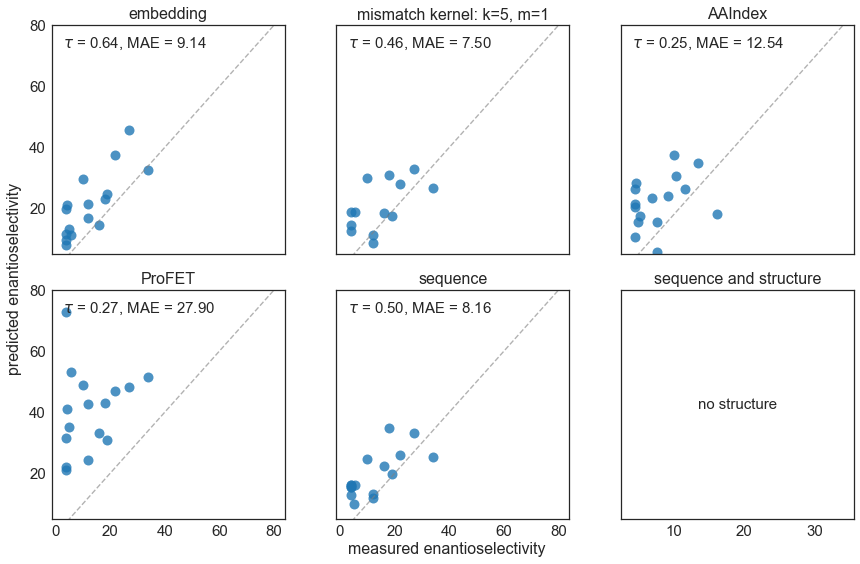

In [11]:
y_col = 'e-value'
dataset = '../inputs/enantioselectivity.txt'
e_dir = '../outputs/enantioselectivity_embeddings/'
emb = 'X_random_3_7.pkl'
df = pd.read_csv(dataset)
df_train = df[df.is_train]
df_test = df[~df.is_train]

y_test = df_test.dropna(subset=[y_col])[y_col]
fig, axs = plt.subplots(2, 3, figsize=(12, 7.5))
fig.tight_layout()


# Sequence 
with open('../inputs/enantioselectivity_seq.pkl', 'rb') as f:
    X, _ = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, 'seq')
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 1], y_test, mu, 'sequence')


# AAIndex
evals, mu = evaluate(df_train, df_test, X_aa['aneh'], y_col, 'aaindex', guesses=(10, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 2], y_test, mu, 'AAIndex')

# ProFET
X_p = pd.read_csv('../inputs/enantioselectivity_profet.tsv', delimiter='\t')
X_p.index = X_p['name']
del X_p['name']
evals, mu = evaluate(df_train, df_test, X_p, y_col, 'profet', guesses=(0.1, 100))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[1, 0], y_test, mu, 'ProFET')


# Mismatch
evals, mu = evaluate_mismatch(df, df_train, df_test, y_col, 5, 1)
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 1], y_test, mu, 'mismatch kernel: k=5, m=1')


# Embedding
with open(e_dir + emb, 'rb')  as f:
    X = pickle.load(f)
evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(10, 10))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 0], y_test, mu, 'embedding')


for i in range(2):
    for j in range(3):
        y0 = 5
        y1 = 80
        axs[i, j].set_ylim([y0, y1])
        if i == 1 and j == 2:
            axs[i, j].set_xlim([x0, x1])
        else:
            x0, x1 = axs[i, j].get_xlim()
            _ = axs[i, j].plot([x0, y1], [x0, y1], '--', color='grey', alpha=0.6)
        if i != 1:
            axs[i, j].get_xaxis().set_visible(False)
        if j != 0:
            axs[i, j].get_yaxis().set_visible(False)
_ = fig.text(0.5, 0.0, 'measured enantioselectivity', ha='center', va='center', fontsize=16)
_ = fig.text(0.0, 0.5, 'predicted enantioselectivity', ha='center', va='center', rotation=90, fontsize=16)
_ = axs[1, 2].set_title('sequence and structure')
_ = axs[1, 2].text(0.5, 0.5, 'no structure', ha='center', va='center', 
              transform=axs[1, 2].transAxes, fontsize=15)

In [12]:
res[res['task'] == 'e-value']

,R,R2,SE,X,d,kendalltau,kernel,log_loss,mae,n_test,n_train,task
17,0.719000,-0.097238,90.285204,seq,8358,0.500167,matern,63.285698,8.159103,16,136,e-value
18,0.341321,-1.366815,194.751113,aaindex,25472,0.249039,matern,65.665810,12.542175,16,136,e-value
19,0.208445,-10.942694,982.693340,profet,1173,0.266215,matern,76.658944,27.903731,16,136,e-value
20,0.664149,-0.072117,88.218161,,NaN,0.455141,mismatch_5_1,65.061992,7.500050,16,136,e-value
21,0.786290,-0.448482,119.186975,X_random_3_7,64,0.644068,matern,64.529940,9.143210,16,136,e-value
